In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
# Upload the data
X_train = pd.read_csv('data/processed/X_train.csv', index_col=0)
X_test = pd.read_csv('data/processed/X_test.csv', index_col=0)
y_train = pd.read_csv('data/processed/y_train.csv', index_col=0)
y_test = pd.read_csv('data/processed/y_test.csv', index_col=0)

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55025 entries, 2905 to 78034
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          55025 non-null  float64
 1   UGDS               55025 non-null  float64
 2   TUITFTE            55025 non-null  float64
 3   INEXPFTE           55025 non-null  float64
 4   PFTFAC             55025 non-null  float64
 5   UG25abv            55025 non-null  float64
 6   COMP_ORIG_YR4_RT   55025 non-null  float64
 7   WDRAW_ORIG_YR4_RT  55025 non-null  float64
 8   ENRL_ORIG_YR4_RT   55025 non-null  float64
 9   DEBT_MDN           55025 non-null  float64
 10  Year               55025 non-null  float64
 11  Cost               55025 non-null  float64
 12  Complete           55025 non-null  float64
 13  RetentionFT        55025 non-null  float64
 14  PREDDEG_1          55025 non-null  float64
 15  PREDDEG_2          55025 non-null  float64
 16  PREDDEG_3          

In [4]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55025 entries, 10080 to 62883
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CURROPER  55025 non-null  bool 
dtypes: bool(1)
memory usage: 483.6 KB


In [5]:
y = y_train.CURROPER.ravel()

# Modeling
## Logistic Regression

Hyperparameters to tune:
- C - inverse of regularization strength; positive float; smaller values are stronger regularization, may lead to underfit model; large C may lead to overfitting
- penalty (l1, l2, elasticnet, none) 
- l1_ratio - for elastic-net paramter mixing: l1_ratio = 0 == L2 penalty; l1_ratio = 1 == L1 penalty, so no need to use l1 and l2 as penalty parameters, since they will be encompassed in the elastic net values

In [6]:
# Import and instantiate model
from sklearn.linear_model import LogisticRegression

In [7]:
# Hyperparameter search
from sklearn.model_selection import RandomizedSearchCV

c_grid = [0.001, 0.01, 0.1, 1, 10]
pen_grid = ['elasticnet']
l1_ratio_grid = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
max_iter_grid = [100, 500, 1000, 1500, 2000]

lr_grid = {'C':c_grid, 'penalty':pen_grid, 'l1_ratio':l1_ratio_grid,'max_iter':max_iter_grid}

Note: trying to use pen_grid = ['none', 'elasticnet'] led to errors, since the l1_ratio parameter is only valid for elastic net penatly, not none. If I want to train a model with no penalty, I will have to run a separate Grid search.

In [8]:
logreg = LogisticRegression(solver = 'saga')
logreg_cv = RandomizedSearchCV(logreg, lr_grid, cv=5)

Note - default solver 'lbfgs' can't handle elasticnet penalty.
Note - with default max_iter = 100, kept getting ConvergenceWarning: The max_iter was reached which means the coef_ did not converge, so I added max_iter as a grid search parameter

In [9]:
start= time.time()
logreg_cv.fit(X_train, y)
end = time.time()
print('GridSearch Time:', end-start)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

GridSearch Time: 437.83195900917053


In [10]:
print("Best params: " , logreg_cv.best_params_)
print("Best score: ", logreg_cv.best_score_)

Best params:  {'penalty': 'elasticnet', 'max_iter': 1500, 'l1_ratio': 0.9, 'C': 0.001}
Best score:  0.8530486142662426


### Grid Results
- Original run: l1_ratio=0.25, max_iter=2000, C=0.001
- Second run: l1_ratio=1, max_iter= 2000, C=0.001
- Third run: l1_ratio = 0.1, max_iter = 2000, C=0.01

### Run the model with the best parameters

In [11]:
modelLR = LogisticRegression(C = 0.01, penalty = 'elasticnet', l1_ratio=0.1, max_iter = 2000, solver = 'saga')
start = time.time()
modelLR.fit(X_train, y)
end = time.time()
print("Fit time = ", end - start)

start = time.time()
lr_pred = modelLR.predict(X_test)
end = time.time()
print("Predict time = ", end - start)

lr_pred_prob = modelLR.predict_proba(X_test)[:, 1]

Fit time =  9.810405015945435
Predict time =  0.0017826557159423828


### Evaluate the model

In [12]:
# Evaluate model
# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, lr_pred))

[[   83  3383]
 [  117 20000]]


In [13]:
# Classification report
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

       False       0.41      0.02      0.05      3466
        True       0.86      0.99      0.92     20117

    accuracy                           0.85     23583
   macro avg       0.64      0.51      0.48     23583
weighted avg       0.79      0.85      0.79     23583



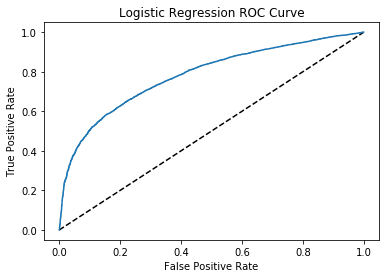

In [14]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, lr_pred_prob)

plt.plot( [0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [15]:
print("AUC: ", roc_auc_score(y_test, lr_pred_prob))

AUC:  0.7829240489587156


In [16]:
# Coefficients
coeffic = modelLR.coef_
coeffic = coeffic[0]
labels = [i for i in X_train.columns]
numLab = len(labels)

In [17]:
coeffic = pd.DataFrame(coeffic, index=labels)
coeffic.columns= ['Coefficient']
coeffic.sort_values(by='Coefficient', inplace=True, ascending=False)
coeffic.head()

,Coefficient
UGDS,0.868420
Year,0.491988
PREDDEG_3,0.364426
Complete,0.118499
DEBT_MDN,0.109524


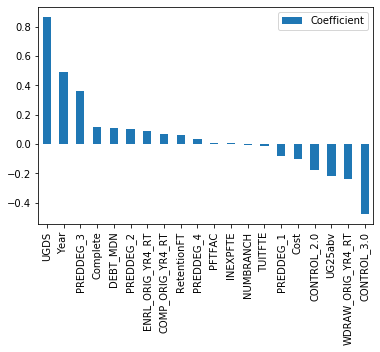

In [18]:
coeffic.plot.bar(y='Coefficient')
#plt.xticks(range(0, numLab), labels, rotation='vertical')
plt.show()

### Coefficient comments
- Enrollment seems to be the most important predictor. [But it's worth checking how many values were imputed]
- Year probably shouldn't be a predictor variable - it was included to distinguish the same schools across different years, to see at which point schools closed... (which I didn't actually explore)
- Preddeg3 = Schools that offer predominantly bachelor's degrees (I think). I think this was the largest group of schools, so it may just be a data balance size issue. (May be predominantly graduate degrees)

- Negative coefficient values
-- Control3 = Private for profit school
-- Control2 = Private nonprofit
--(So does this mean that public schools have no effect, or positive coeff value?)
- Withdraw
- UG25abv 

## Decision Tree
Parameters to search:
- max_features
- max_depth
- min_samples_leaf

In [19]:
from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import RandomizedSearchCV

In [20]:
criterion_grid = ['gini', 'entropy']
max_depth_grid = ['None', 3, 5, 10, 20, 50, 75, 100]
min_sample_split_grid = [2, 5, 10, 25, 50, 75, 100]
min_samples_leaf_grid = [2, 5, 10, 25, 50]
feature_grid = ["auto", "log2", 4, 5, 10, 12, 15, 20]

dtc_grid = {'criterion': criterion_grid, 
              'max_depth':max_depth_grid,
              'min_samples_split':min_sample_split_grid,
              'min_samples_leaf':min_samples_leaf_grid,
              'max_features':feature_grid }

In [21]:
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, dtc_grid, cv=5)
tree_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [22]:
print("Best params: " , tree_cv.best_params_)
print("Best score: ", tree_cv.best_score_)

Best params:  {'min_samples_split': 100, 'min_samples_leaf': 25, 'max_features': 15, 'max_depth': 50, 'criterion': 'entropy'}
Best score:  0.8706042707860064


### Grid Search Results
- First run: min_sample_split=2; min_samples_leaf=25; max_features=20, max_depth=20, criterion=entropy
- Second run: min_sample_split=75, min_samples_leaf=25; max_features=20, max_depth=20, criterion='entropy'

In [23]:
# Train the decision tree using the identified hyperparameters
modelDT = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, min_samples_leaf=25, 
                                 max_features=20, max_depth=20)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[Text(154.85823864059523, 212.26285714285714, 'X[19] <= 0.13\nentropy = 0.602\nsamples = 55025\nvalue = [8086, 46939]'),
 Text(80.00053852574307, 201.90857142857143, 'X[1] <= -0.307\nentropy = 0.363\nsamples = 31119\nvalue = [2155, 28964]'),
 Text(55.42060287540004, 191.5542857142857, 'X[0] <= 1.652\nentropy = 0.595\nsamples = 11685\nvalue = [1683, 10002]'),
 Text(32.96589593192496, 181.2, 'X[1] <= -0.468\nentropy = 0.562\nsamples = 11501\nvalue = [1515, 9986]'),
 Text(6.975949884243498, 170.84571428571428, 'X[17] <= 2.366\nentropy = 0.936\nsamples = 995\nvalue = [350, 645]'),
 Text(4.468255481410868, 160.49142857142857, 'X[10] <= 0.099\nentropy = 0.974\nsamples = 793\nvalue = [321, 472]'),
 Text(2.370911071769032, 150.13714285714286, 'X[11] <= -1.102\nentropy = 1.0\nsamples = 472\nvalue = [231, 241]'),
 Text(1.641399972763176, 139.78285714285715, 'X[3] <= -0.005\nentropy = 0.672\nsamples = 51\nvalue = [9, 42]'),
 Text(1.2766444232602479, 129.42857142857144, 'entropy = 0.242\nsamples =

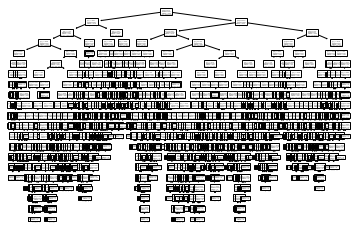

In [24]:
from sklearn.tree import plot_tree
plot_tree(modelDT)

In [25]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict(X_test)

In [26]:
# Run this block for model evaluation 
from sklearn import metrics
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))


Model Metrics
Accuracy: 0.8752491201289064
Balanced accuracy: 0.7057417225216327
Precision score for "Yes" 0.911298433833038
Recall score for "No" 0.465666474321985


In [27]:
print(confusion_matrix(y_test, dt_pred))

[[ 1614  1852]
 [ 1090 19027]]


In [28]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.60      0.47      0.52      3466
        True       0.91      0.95      0.93     20117

    accuracy                           0.88     23583
   macro avg       0.75      0.71      0.73     23583
weighted avg       0.87      0.88      0.87     23583



## Random Forest Classifier

Hyperparameters:
- number of features per tree
- number of trees per forest (n_estimators)
- depth(?)

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
n_tree_grid = [10,50,100,200,250,500]
crit_grid = ['gini', 'entropy']
max_depth_grid = ['None', 3, 5, 10, 15, 20]
min_sample_split_grid = [2, 5, 10, 20]
min_samples_leaf_grid = [2, 5, 10, 25, 50]
feature_grid = ["auto", "log2", 4, 5, 10, 12, 15, 20]

rfc_grid = {'n_estimators':n_tree_grid,
              'criterion': crit_grid, 
              'max_depth':max_depth_grid,
              'min_samples_split':min_sample_split_grid,
              'min_samples_leaf':min_samples_leaf_grid,
              'max_features':feature_grid }

In [31]:
forest = RandomForestClassifier()
start = time.time()
forest_cv = RandomizedSearchCV(forest, rfc_grid, cv=5)
forest_cv.fit(X_train, y)
end = time.time()
print("GridSearch time: ", end-start)

GridSearch time:  1800.844622850418


In [32]:
print("Best params: " , forest_cv.best_params_)
print("Best score: ", forest_cv.best_score_)

Best params:  {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 10, 'max_depth': 20, 'criterion': 'entropy'}
Best score:  0.8948659700136302


### Grid Search Results
- First run: n_estimators=200; min_sample_split=2; min_samples_leaf=2, max_features=10; max_depth=15; criterion='gini'
- Second run: n_estimators=50; min_sample_split=5; min_samples_leaf=25; max_features=10; max_depth=10; criterion='gini'

In [33]:
modelRF = RandomForestClassifier(n_estimators = 200, min_samples_split=2, 
                                 min_samples_leaf=2, max_features=10,
                                max_depth=10, criterion='gini')
modelRF.fit(X_train, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
rf_pred = modelRF.predict(X_test)
rf_pred_prob = modelRF.predict_proba(X_test)

In [35]:
print("Random Forest Classifier model")
print("Accuracy:", metrics.accuracy_score(y_test, rf_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, rf_pred))
print('Precision score for Yes' , metrics.precision_score(y_test, rf_pred, pos_label = 1))
print('Recall score for No' , metrics.recall_score(y_test, rf_pred, pos_label = 0))

Random Forest Classifier model
Accuracy: 0.8841538396302421
Balanced accuracy: 0.6534085037039953
Precision score for Yes 0.8941640593116583
Recall score for No 0.32660126947489904


In [36]:
print(confusion_matrix(y_test, rf_pred))

[[ 1132  2334]
 [  398 19719]]


In [37]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

       False       0.74      0.33      0.45      3466
        True       0.89      0.98      0.94     20117

    accuracy                           0.88     23583
   macro avg       0.82      0.65      0.69     23583
weighted avg       0.87      0.88      0.86     23583



## Random Forest Regression

I have decided that I don't need a regression model, since my response variable boolean (categorical).

- n_estimators (default = 100)
- max_depth
- min_samples_split
- min_samples_leaf
- max_features

In [38]:
# from sklearn.ensemble import RandomForestRegressor

In [39]:
# n_tree_grid = [10,50,100,200,250,500]
# crit_grid = ['mse', 'mae']
# max_depth_grid = ['None', 3, 5, 10, 15, 20]
# min_sample_split_grid = [2, 5, 10, 20]
# min_samples_leaf_grid = [2, 5, 10, 25, 50]
# feature_grid = ["auto", "log2", 4, 5, 10, 12, 15, 20]

# rfr_grid = {'n_estimators':n_tree_grid,
#               'criterion': crit_grid, 
#               'max_depth':max_depth_grid,
#               'min_samples_split':min_sample_split_grid,
#               'min_samples_leaf':min_samples_leaf_grid,
#               'max_features':feature_grid }

In [40]:
# forestReg = RandomForestRegressor()
# start = time.time()
# forestreg_cv = RandomizedSearchCV(forestReg, rfr_grid, cv=5)
# forestreg_cv.fit(X_train, y)
# end = time.time()
# print("GridSearch time: ", end-start)

In [41]:
# print("Best params: " , forestreg_cv.best_params_)
# print("Best score: ", forestreg_cv.best_score_)

In [42]:
# modelRFR = RandomForestRegressor(n_estimators =_, ...)
# modelRFR.fit(X_train, y)

In [43]:
# rfr_pred = modelRFR.predict(X_test)
# rfr_pred_prob = modelRFR.predict_proba(X_test)

In [44]:
# print("Random Forest Regression model")
# print("Accuracy:", metrics.accuracy_score(y_test, rfr_pred))
# print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, rfr_pred))
# #print('Precision score' , metrics.precision_score(y_test, rf_pred, pos_label = "Yes"))
# #print('Recall score' , metrics.recall_score(y_test, rf_pred, pos_label = "No"))

In [45]:
# print(confusion_matrix(y_test, rfr_pred))

In [46]:
# print(classification_report(y_test, rfr_pred))